In [38]:
import pandas as pd
import numpy as np

In [39]:
df=pd.read_csv('./data/버스·지하철·택시 수요 변화와 자동차 대수 변화율.csv')

In [40]:
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(precision=2, suppress=True)

In [41]:
df.head()

,연도,구,소계,버스,지하철,택시,자동차_대수,자동차_증감
0,2021,종로구,141759969,57821751,75771163,8167055,50049,-11.00
1,2021,중구,149856039,39190006,100938579,9727454,53107,1947.00
2,2021,용산구,87031985,43905878,32335411,10790696,79486,3005.00
3,2021,성동구,96087425,31552270,56470250,8064905,106435,905.00
4,2021,광진구,95731490,29859594,56633974,9237922,98658,-114.00


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연도      100 non-null    int64  
 1   구       100 non-null    object 
 2   소계      100 non-null    int64  
 3   버스      100 non-null    int64  
 4   지하철     100 non-null    int64  
 5   택시      100 non-null    int64  
 6   자동차_대수  100 non-null    int64  
 7   자동차_증감  100 non-null    float64
dtypes: float64(1), int64(6), object(1)
memory usage: 6.4+ KB


In [43]:
df.describe()

,연도,소계,버스,지하철,택시,자동차_대수,자동차_증감
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,2022.50,134997412.58,59278241.14,66560936.53,9158234.91,127183.23,624.43
std,1.12,52439313.39,17100364.79,36717932.00,5117461.86,50076.37,2070.99
min,2021.00,66752284.00,29859594.00,19830665.00,3556554.00,50049.00,-3984.00
25%,2021.75,96055099.75,46170210.25,36366522.75,6202428.00,95333.00,-478.25
50%,2022.50,118954686.00,58450700.50,56552112.00,7909313.50,118517.00,195.00
75%,2023.25,167148753.00,69437945.25,89981585.25,10891454.50,151636.50,1508.00
max,2024.00,322927844.00,111266706.00,179953430.00,31707708.00,256099.00,9965.00


In [44]:
df[['버스', '지하철', '택시', '자동차_증감']].corr()

,버스,지하철,택시,자동차_증감
버스,1.00,0.55,0.53,0.15
지하철,0.55,1.00,0.78,0.14
택시,0.53,0.78,1.00,0.33
자동차_증감,0.15,0.14,0.33,1.00


In [45]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'   # 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False  

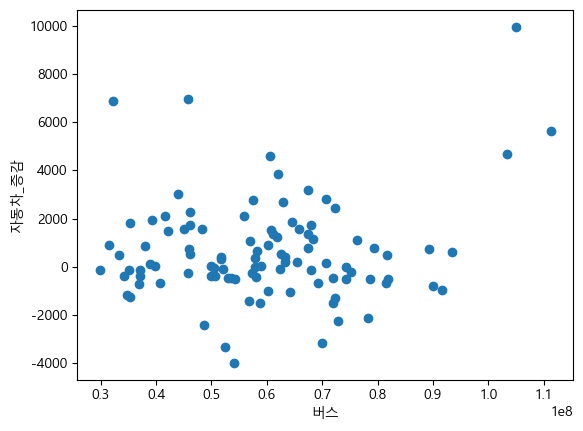

In [46]:
plt.scatter(df['버스'], df['자동차_증감'])
plt.xlabel('버스')
plt.ylabel('자동차_증감')
plt.show()

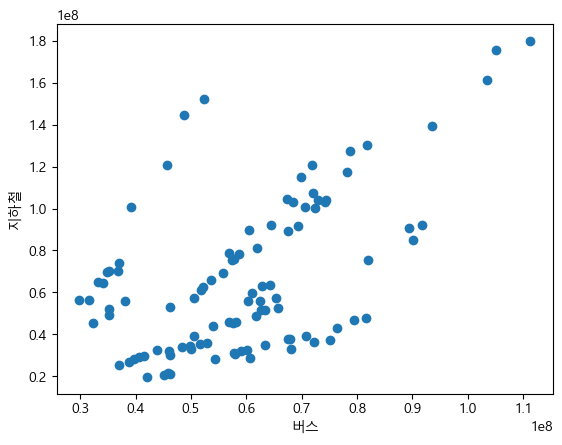

In [47]:
plt.scatter(df['버스'], df['지하철'])
plt.xlabel('버스')
plt.ylabel('지하철')
plt.show()

In [48]:
#다항회귀 모델 작업

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

X = df[['버스', '지하철', '택시']]
y = df['자동차_증감']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
#전처리

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

#R2는 결정계수 과적합

model = LinearRegression()
model.fit(X_train_poly, y_train)

print("train R2:", model.score(X_train_poly, y_train))
print("test  R2:", model.score(X_test_poly, y_test))

train R2: 0.3978897495563234
test  R2: -1.5642346770012923


In [51]:
# 입력 변수들을 2차 다항식으로 늘린 뒤, 스케일을 맞추고, 규제된 선형회귀(Ridge)로 학습하여 train/test R²로 성능을 평가한다.
# 과적합 감소, 방향은 맞음 
# test가 여전히 음수
# → 아직 설명력이 부족 (α·degree·모델 재검토 필요)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

pipe.fit(X_train, y_train)

print("train R2:", pipe.score(X_train, y_train))
print("test  R2:", pipe.score(X_test, y_test))

train R2: 0.3046704699369751
test  R2: -0.7822748758644629


In [52]:
# α만 먼저 튜닝, test가 여전히 음수

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

results = []
for a in alphas:
    pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=a))
    ])
    pipe.fit(X_train, y_train)

    train_r2 = pipe.score(X_train, y_train)
    test_r2  = pipe.score(X_test, y_test)

    results.append((a, train_r2, test_r2))
    print(f"alpha={a:>7} | train R2={train_r2: .4f} | test R2={test_r2: .4f}")

# test R2가 가장 큰 alpha 확인
best = max(results, key=lambda x: x[2])
print("\nBest by test R2:", best) 


alpha=  0.001 | train R2= 0.3979 | test R2=-1.5425
alpha=   0.01 | train R2= 0.3955 | test R2=-1.3878
alpha=    0.1 | train R2= 0.3581 | test R2=-0.9745
alpha=      1 | train R2= 0.3047 | test R2=-0.7823
alpha=     10 | train R2= 0.2705 | test R2=-0.6811
alpha=    100 | train R2= 0.2006 | test R2=-0.5182
alpha=   1000 | train R2= 0.0967 | test R2=-0.3401

Best by test R2: (1000, 0.09665497737374473, -0.3401073890954509)


In [53]:
#1차, 2차 다중선형회귀 확인, 1차 다중회귀가 더나음


best_alpha = best[0]  # 위 코드에서 best로 뽑힌 alpha 사용

for d in [1, 2]:
    pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=best_alpha))
    ])
    pipe.fit(X_train, y_train)
    print(f"degree={d} | train R2={pipe.score(X_train, y_train): .4f} | test R2={pipe.score(X_test, y_test): .4f}")


degree=1 | train R2= 0.0333 | test R2=-0.2975
degree=2 | train R2= 0.0967 | test R2=-0.3401


In [54]:
# “2차 다항 회귀는 과적합을 유발했으며,
# 규제 후에도 test 성능이 개선되지 않았다.
# 1차 선형모델이 상대적으로 안정적이었으나,
# 전반적으로 설명력은 낮아 변수/타깃 재정의가 필요하다.”

In [55]:
# 2022~2024년 전 시점 대비 자동차대수 변화율

y = df['자동차_대수'].pct_change().dropna()
X = df[['버스', '지하철', '택시']].loc[y.index]

In [56]:
# plt.hist(y, bins=10)
# plt.title("y (자동차 대수 변화율) 분포")
# plt.show()

# # X와 y 상관
# print(X.corrwith(y))

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

pipe = Pipeline([
    ("scaler", StandardScaler()),   # 스케일 정규화
    ("ridge", Ridge(alpha=1.0))     # 1차 선형 + 규제
])

pipe.fit(X_train, y_train)

print("train R2:", pipe.score(X_train, y_train))
print("test  R2:", pipe.score(X_test, y_test))

train R2: 0.23742122870351345
test  R2: 0.002863479603916974


In [59]:
for a in [0.01, 0.1, 1, 10, 100]:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=a))
    ])
    pipe.fit(X_train, y_train)
    print(f"alpha={a} | test R2={pipe.score(X_test, y_test):.4f}")

alpha=0.01 | test R2=-0.0020
alpha=0.1 | test R2=-0.0015
alpha=1 | test R2=0.0029
alpha=10 | test R2=0.0292
alpha=100 | test R2=0.0324


In [60]:
# α=100 기준

coef = pipe.named_steps['ridge'].coef_
for name, c in zip(X.columns, coef):
    print(name, c)

버스 -0.010237702833022173
지하철 0.03363610840007326
택시 0.05806718198842119


In [61]:
# best α = 100
# test R² ≈ 0.03 (아주 약하지만 0 이상)

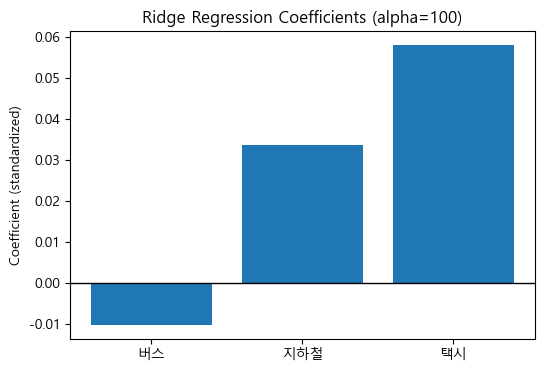

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# alpha=100 모델이 마지막 pipe에 들어있다는 전제
coef = pipe.named_steps['ridge'].coef_
features = X.columns

plt.figure(figsize=(6,4))
plt.bar(features, coef)
plt.axhline(0, color='black', linewidth=1)

plt.title("Ridge Regression Coefficients (alpha=100)")
plt.ylabel("Coefficient (standardized)")
plt.show()

In [63]:
# “표준화 기준에서 택시 > 지하철 > 버스 순으로 양(+)의 연관성이 관측되며, 버스는 약한 음(-)의 방향을 보인다.”

# 버스 이용(또는 공급)이 늘어난 곳에서는 자동차 증가율이 조금 낮아지는 경향
# 지하철 수요와 택시수요가 많으면 있을수록 자동차 대수도 조금은 증가한다

# “대중교통 지표(버스·지하철·택시)는 자동차 대수의 단기 변화율을 설명하는 데 
# 제한적인 역할만을 보였으며, 규제 회귀 기준에서도 test R²가 0.03 수준에 그쳐 예측·설명력은 매우 약한 것으로 판단된다.”


# 버스·지하철·택시 수요 변화만으로는
# 자동차 대수 변화율을 유의미하게 설명하거나 예측하기 어렵다.